# Model

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile

2024-12-22 20:33:24.676206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 20:33:24.792773: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 20:33:25.423515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-12-22 20:33:25.423573

## Model Creation

Create custom model based on microsoft ResNet 50

In [2]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
base_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


class CustomResNetModel(nn.Module):
    def __init__(self, base_model, num_classes=3):
        super(CustomResNetModel, self).__init__()
        
        for name, param in base_model.named_parameters():
            if "encoder.stages.3" in name or "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.resnet = base_model 
        self.dropout1 = nn.Dropout(p=0.5)
        self.dense1 = nn.Linear(1000, 512) 
        self.dense2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dense3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.resnet(x).logits 
        x = self.dropout1(x)
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dropout2(x)
        x = torch.relu(self.dense3(x))
        x = self.output(x) 
        return x

num_classes = 2
custom_model = CustomResNetModel(base_model, num_classes=num_classes)


Print the structure of the model

In [3]:
print(custom_model)

CustomResNetModel(
  (resnet): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (encoder): ResNetEncoder(
        (stages): ModuleList(
          (0): ResNetStage(
            (layers): Sequential(
              (0): ResNetBottleNeckLayer(
                (shortcut): ResNetShortCut(
                  (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (layer): Sequential(
           

Print frozen and trainable parameters of model

In [4]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

resnet.resnet.embedder.embedder.convolution.weight: Frozen
resnet.resnet.embedder.embedder.normalization.weight: Frozen
resnet.resnet.embedder.embedder.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.0.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.normalization.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.1.normalization.bias: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.2.convolution.weight: Frozen
resnet.resnet.encoder.stages.0.layers.0.layer.2.normalization.

## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [5]:
# with zipfile.ZipFile("original_data.zip", 'r') as zip_ref:
#     zip_ref.extractall("")

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root="original_data", transform=transform)

class_indices = {class_name: [] for class_name in dataset.classes}
for idx, (image, label) in enumerate(dataset):
    class_indices[dataset.classes[label]].append(idx)

for x in class_indices:
    print(f"{x}: {len(class_indices[x])} images")

train_indices = []
test_indices = []

for class_name in dataset.classes:
    indices = class_indices[class_name]
    train_indices.extend(indices[:int(len(indices)*.75)])
    test_indices.extend(indices[int(len(indices)*.75):len(indices)-1])

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

normal: 1323 images
pneumonia: 1323 images


In [7]:
print(dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}


In [8]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1984
Test dataset size: 660


In [9]:
from collections import Counter

def count_classes_in_subset(subset, original_dataset):
    subset_labels = [original_dataset.targets[idx] for idx in subset.indices]
    class_counts = Counter(subset_labels)
    class_name_counts = {original_dataset.classes[idx]: count for idx, count in class_counts.items()}
    return class_name_counts

train_class_counts = count_classes_in_subset(train_dataset, dataset)
test_class_counts = count_classes_in_subset(test_dataset, dataset)

print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: {'normal': 992, 'pneumonia': 992}
Test class counts: {'normal': 330, 'pneumonia': 330}


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


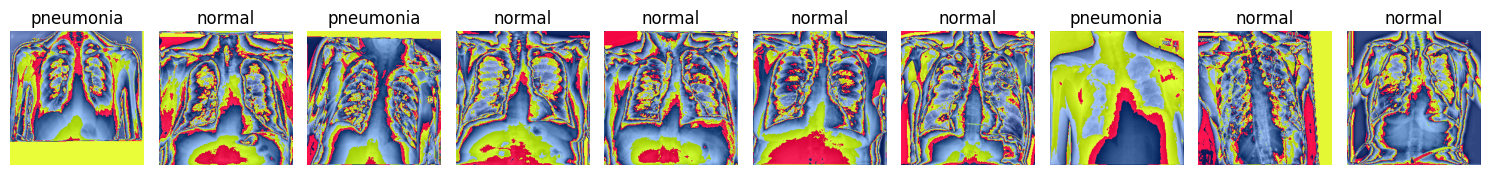

In [11]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Model Training And Evaluation

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [13]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=1e-5)

num_epochs = 24
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, num_epochs)

Device using for training: cuda


Epoch [1/24]: 100%|██████████| 62/62 [00:48<00:00,  1.27batch/s]


Epoch [1/24], Train Loss: 0.7254, Train Accuracy: 51.97%, Test Loss: 0.7035, Test Accuracy: 50.00%


Epoch [2/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [2/24], Train Loss: 0.6954, Train Accuracy: 50.76%, Test Loss: 0.6874, Test Accuracy: 51.36%


Epoch [3/24]: 100%|██████████| 62/62 [00:47<00:00,  1.32batch/s]


Epoch [3/24], Train Loss: 0.6839, Train Accuracy: 57.11%, Test Loss: 0.6813, Test Accuracy: 58.79%


Epoch [4/24]: 100%|██████████| 62/62 [00:46<00:00,  1.33batch/s]


Epoch [4/24], Train Loss: 0.6740, Train Accuracy: 60.53%, Test Loss: 0.6720, Test Accuracy: 62.58%


Epoch [5/24]: 100%|██████████| 62/62 [00:47<00:00,  1.32batch/s]


Epoch [5/24], Train Loss: 0.6577, Train Accuracy: 64.06%, Test Loss: 0.6617, Test Accuracy: 63.33%


Epoch [6/24]: 100%|██████████| 62/62 [00:47<00:00,  1.31batch/s]


Epoch [6/24], Train Loss: 0.6365, Train Accuracy: 65.22%, Test Loss: 0.6515, Test Accuracy: 63.33%


Epoch [7/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [7/24], Train Loss: 0.6115, Train Accuracy: 66.68%, Test Loss: 0.6484, Test Accuracy: 63.79%


Epoch [8/24]: 100%|██████████| 62/62 [00:46<00:00,  1.33batch/s]


Epoch [8/24], Train Loss: 0.5849, Train Accuracy: 69.61%, Test Loss: 0.6495, Test Accuracy: 62.88%


Epoch [9/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [9/24], Train Loss: 0.5604, Train Accuracy: 71.47%, Test Loss: 0.6518, Test Accuracy: 64.09%


Epoch [10/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [10/24], Train Loss: 0.5281, Train Accuracy: 73.89%, Test Loss: 0.6525, Test Accuracy: 63.48%


Epoch [11/24]: 100%|██████████| 62/62 [00:47<00:00,  1.32batch/s]


Epoch [11/24], Train Loss: 0.4995, Train Accuracy: 75.60%, Test Loss: 0.6601, Test Accuracy: 61.82%


Epoch [12/24]: 100%|██████████| 62/62 [00:47<00:00,  1.31batch/s]


Epoch [12/24], Train Loss: 0.4665, Train Accuracy: 78.18%, Test Loss: 0.6721, Test Accuracy: 63.03%


Epoch [13/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [13/24], Train Loss: 0.4323, Train Accuracy: 80.95%, Test Loss: 0.6811, Test Accuracy: 62.73%


Epoch [14/24]: 100%|██████████| 62/62 [00:46<00:00,  1.34batch/s]


Epoch [14/24], Train Loss: 0.3965, Train Accuracy: 84.02%, Test Loss: 0.7024, Test Accuracy: 61.97%


Epoch [15/24]: 100%|██████████| 62/62 [00:45<00:00,  1.35batch/s]


Epoch [15/24], Train Loss: 0.3478, Train Accuracy: 86.19%, Test Loss: 0.7416, Test Accuracy: 61.06%


Epoch [16/24]: 100%|██████████| 62/62 [00:46<00:00,  1.33batch/s]


Epoch [16/24], Train Loss: 0.3064, Train Accuracy: 88.76%, Test Loss: 0.7613, Test Accuracy: 62.42%


Epoch [17/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [17/24], Train Loss: 0.2656, Train Accuracy: 90.83%, Test Loss: 0.7991, Test Accuracy: 61.67%


Epoch [18/24]: 100%|██████████| 62/62 [00:47<00:00,  1.32batch/s]


Epoch [18/24], Train Loss: 0.2210, Train Accuracy: 93.45%, Test Loss: 0.8492, Test Accuracy: 61.67%


Epoch [19/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [19/24], Train Loss: 0.1827, Train Accuracy: 94.81%, Test Loss: 0.8810, Test Accuracy: 61.06%


Epoch [20/24]: 100%|██████████| 62/62 [00:47<00:00,  1.32batch/s]


Epoch [20/24], Train Loss: 0.1382, Train Accuracy: 97.18%, Test Loss: 0.9226, Test Accuracy: 60.61%


Epoch [21/24]: 100%|██████████| 62/62 [00:46<00:00,  1.34batch/s]


Epoch [21/24], Train Loss: 0.1080, Train Accuracy: 98.24%, Test Loss: 0.9627, Test Accuracy: 61.36%


Epoch [22/24]: 100%|██████████| 62/62 [00:46<00:00,  1.32batch/s]


Epoch [22/24], Train Loss: 0.0824, Train Accuracy: 98.74%, Test Loss: 1.0544, Test Accuracy: 61.06%


Epoch [23/24]: 100%|██████████| 62/62 [00:46<00:00,  1.33batch/s]


Epoch [23/24], Train Loss: 0.0627, Train Accuracy: 99.24%, Test Loss: 1.1134, Test Accuracy: 61.21%


Epoch [24/24]: 100%|██████████| 62/62 [00:47<00:00,  1.31batch/s]


Epoch [24/24], Train Loss: 0.0467, Train Accuracy: 99.55%, Test Loss: 1.1475, Test Accuracy: 61.21%


## Model Evaluation

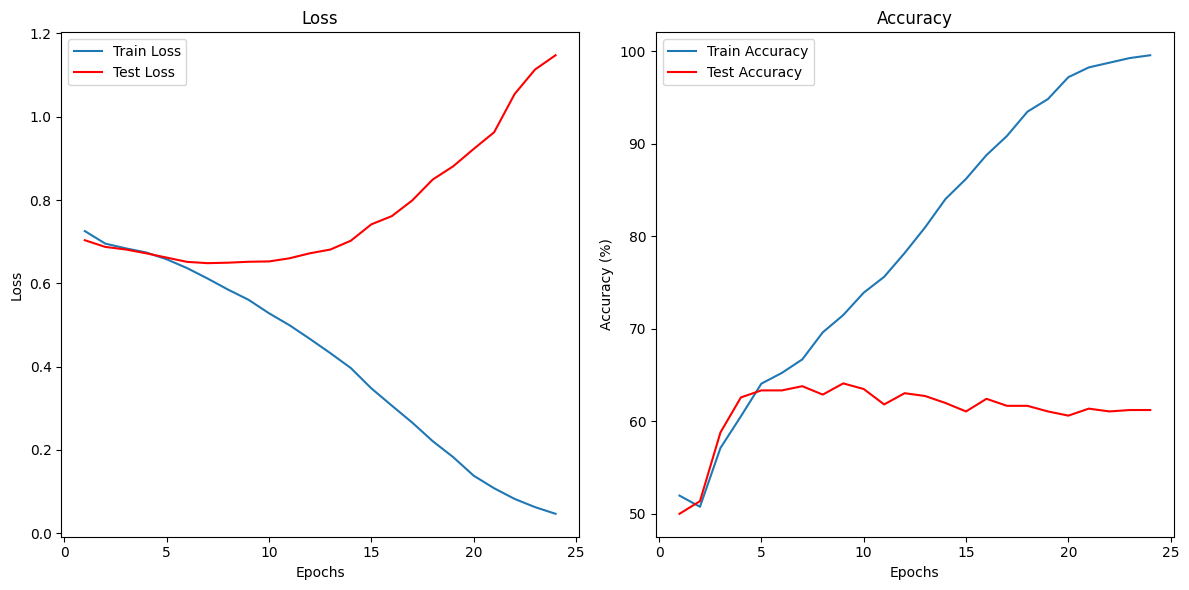

In [15]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Model Saving

In [18]:
torch.save(custom_model.state_dict(), "modelv3.1.pth")